# The North Face ecommerce project

We study here an e-commerce product catalog composed of 500 item descriptions, each containing about 100 words. For this project, we focus solely on information retrieval from the descriptions. We therefore limit ourselves to statistical approaches to natural language processing. 
This project illustrates the following common tasks in NLP:
- The preprocessing of documents: cleaning spurious tokens, selecting tokens and lemmatization;
- The conversion of the corpus into a TF-IDF matrix;
- The clustering of high dimensional data;
- Dimensionality reduction for topic extraction.

Contents
--------
1. [Data loading and preprocessing](#loading)
2. [Descriptions clustering](#clustering)
3. [Recommender system](#recommend)
4. [Topic modeling](#topic)
5. [Conclusion and perspectives](#conclusion)

In [1]:
import csv
import re

import numpy as np
import pandas as pd
import spacy
import wordcloud
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

## <a id="loading"></a> Data loading and preprocessing

### Preparation of the corpus

The corpus is prepared by performing the following transformations to each description:
- remove HTML tags,
- remove punctuation,
- remove numbers,
- remove stop words,
- normalize to lowercase

We use the lightweight english model `en_core_web_md` to lemmatize and select words. The model can be downloaded with `python -m spacy download en_core_web_sm`.

The resulting corpus is a list of strings, each containing the relevant words of the description separated by whitespaces.

In [2]:
## Load the file
with open('./sample-data.csv', 'rt', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',', quoting=csv.QUOTE_STRINGS)
    next(reader, None) # remove header
    data = [row for row in reader]

description_id = [int(row[0]) for row in data]
descriptions = [row[1] for row in data]

In [3]:
## remove HTML tags
descriptions = [re.sub(r'<[a-z/]+>', ' ', d) for d in descriptions]

In [4]:
## filter words and normalize into lowercase lemmas
nlp = spacy.load('en_core_web_sm')
corpus = []
for desc in descriptions:
    doc = nlp(desc)
    doc = ' '.join(wd.lemma_.lower() for wd in doc
                   if wd.is_alpha and not wd.is_stop)
    corpus.append(doc)
corpus = np.array(corpus, dtype=object)

### A first word cloud

We illustrate the corpus composition by displaying a word cloud of its contents.

In [5]:
def create_wordcloud(text_or_freqs: str | dict[str, float],
                     **kwargs)-> np.ndarray:
    """
    Create a wordcloud from a text or a dict of word frequencies. Keyword args
    are passed to the WordCloud initializer.
    
    Returns the wordcloud image as a 3D np.ndarray of shape (height, width, 3).
    """
    defaults = {'width': 1000, 'height': 500, 'min_font_size': 12,
                'colormap': 'gist_rainbow', 'collocations': False,
                'random_state': 1234}    
    wc = wordcloud.WordCloud(**(defaults | kwargs))
    if isinstance(text_or_freqs, str):
        wc = wc.generate(text_or_freqs)
    elif isinstance(text_or_freqs, dict):
        wc = wc.generate_from_frequencies(text_or_freqs)
    else:
        raise TypeError('`text_or_freqs` must be of type `str` or `dict`')
    return wc.to_array()

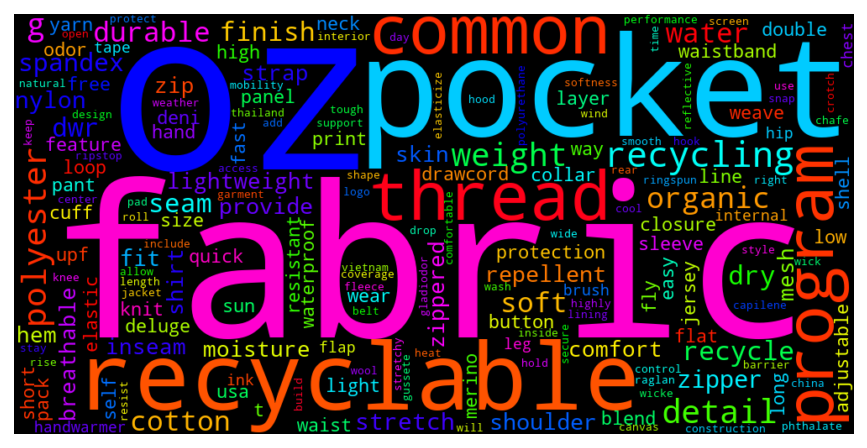

In [6]:
corpus_wc = create_wordcloud(' '.join(corpus))
xy_ratio = corpus_wc.shape[0] / corpus_wc.shape[1]

wc_fig1 = plt.figure(figsize=(6, 6*xy_ratio), dpi=140)
wc_ax1 = wc_fig1.add_axes(rect=(0, 0, 1, 1))

wc_ax1.axis('off')
wc_ax1.imshow(corpus_wc, interpolation='bilinear')

plt.show()

The topic of the corpus is obvious: 'fabric', 'pocket', 'thread', 'polyester', 'seam'. We are in the presence of garments descriptions. However, we note the proeminence of ubiquitous words such as 'oz' (referring to the weight), 'fabric', 'recyclable', 'common', etc.

### Construction of the TF-IDF matrix

For the purpose of description clustering, we compute the TF-IDF weights of the documents contents. This transform reduces the importance of those common words that dominate the corpus. We normalize out TF-IDF vectors with respect to the $L^2$-norm.

In [7]:
vectorizer = CountVectorizer(token_pattern=r'[^\s]+')
word_counts = vectorizer.fit_transform(corpus)

vocabulary = vectorizer.get_feature_names_out()
tfidf = TfidfTransformer(norm='l2').fit_transform(word_counts)

## <a id="clustering"></a> Descriptions clustering

Our goal is to categorize the items from their descriptions. Clustering methods are well-suited for this task. However, our data lies in high dimension (3637), with only 500 observations. This prohibits the use of methods such as $k$-means clustering. Indeed, in high dimension, observations are likely to be far from each other, hence a large variance for clusters. This in turn makes $k$-means clustering likely to fall into local minima. We thus favor deterministic approaches such as DBSCAN for our clustering.

### Clustering with DBSCAN

DBSCAN clustering is dependent on two parameters:
- $\epsilon$ (`eps`), the maximum distance between two samples to consider them as neighbors,
- $n_{\mathrm{samples}}$ (`min_samples`), the minimum number of neighbors to be considered a core point. DBSCAN also suffers from high dimensionality. Searching manually for parameters that gives a good clustering is tedious. We instead rely on a grid search to select the appropriate values.

In [8]:
## Setup scanned parameters
eps_vals = np.linspace(0.5, 0.9, 21)
min_samples_vals = np.arange(1, 16, 1)
sh = (len(min_samples_vals), len(eps_vals))

## Grid search and record number of clusters and outliers
nb_clusters = np.zeros(sh, dtype=int)
nb_outliers = np.zeros(sh, dtype=int)
for i, j in np.ndindex(sh):
    dbc = DBSCAN(eps=eps_vals[j], min_samples=min_samples_vals[i],
                 metric='cosine', leaf_size=1)
    dbc = dbc.fit(tfidf)
    dbc_labels = dbc.labels_
    nb_clusters[i, j] = len(np.unique(dbc_labels)) - 1
    nb_outliers[i, j] = np.sum(dbc_labels==-1)

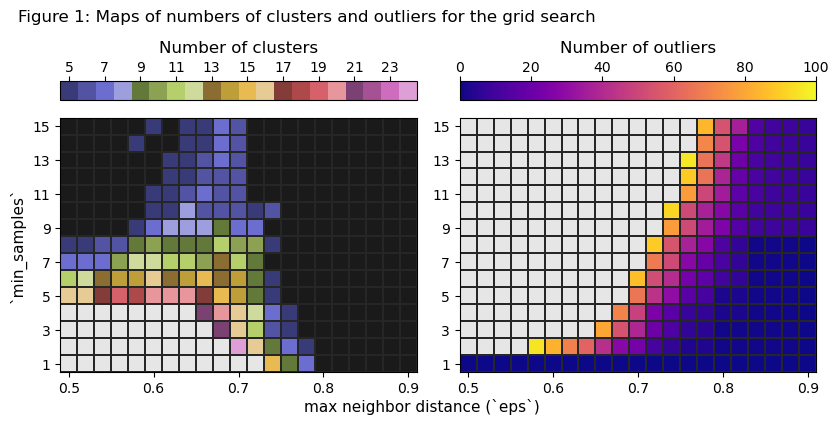

In [9]:
fig1, axs1 = plt.subplots(
    nrows=2, ncols=2, sharex=False, sharey=False, figsize=(8.4, 4.2), dpi=100,
    gridspec_kw={'left': 0.07, 'right': 0.97, 'top': 0.81, 'bottom': 0.09,
                 'height_ratios': [0.07, 1], 'hspace': 0.04, 'wspace': 0.12})
fig1.suptitle("Figure 1: Maps of numbers of clusters and outliers for the grid search",
              x=0.02, ha='left', fontsize=12)


axs1[1, 0].set_aspect('equal')
cmap1 = plt.get_cmap('tab20b').copy()
cmap1.set_extremes(under='0.1', over='0.9')
heatmap1 = axs1[1, 0].pcolormesh(nb_clusters, cmap=cmap1, vmin=4.5, vmax=24.5,
                                 edgecolors='0.15', linewidth=0.05)

axs1[1, 0].set_xticks(np.linspace(0.5, 20.5, 5), eps_vals[::5])
axs1[1, 0].set_yticks(np.linspace(0.5, 14.5, 8), min_samples_vals[::2])
axs1[1, 0].set_ylabel('`min_samples`', fontsize=11)
fig1.text(0.5, 0.022, 'max neighbor distance (`eps`)', fontsize=11, ha='center')

fig1.colorbar(heatmap1, cax=axs1[0, 0], orientation='horizontal', ticklocation='top')
axs1[0, 0].tick_params(pad=1)
axs1[0, 0].set_xticks(np.linspace(5, 23, 10), np.arange(5, 24, 2))
axs1[0, 0].set_title('Number of clusters')


axs1[1, 1].set_aspect('equal')
cmap2 = plt.get_cmap('plasma').copy()
cmap2.set_extremes(under='0.1', over='0.9')
heatmap2 = axs1[1, 1].pcolormesh(nb_outliers, cmap=cmap2, vmin=0, vmax=100,
                                 edgecolors='0.15', linewidth=0.1)

axs1[1, 1].set_xticks(np.linspace(0.5, 20.5, 5), eps_vals[::5])
axs1[1, 1].set_yticks(np.linspace(0.5, 14.5, 8), min_samples_vals[::2])

fig1.colorbar(heatmap2, cax=axs1[0, 1], orientation='horizontal', ticklocation='top')
axs1[0, 1].tick_params(pad=1)
axs1[0, 1].set_title('Number of outliers')


plt.show()

Figure 1 shows maps of the number of clusters (left panel) and number of outliers (right panel) as a function of the values of `eps` and `min_samples`. We recover the intuitive behavior of parameters. Increasing `min_samples`/decreasing `eps` tends to isolate the points: the number of clusters decreases and the number of outliers increases.

The black and white regions correspond to values below and above the colorbar range, respectively. Parameter values that fall in these domains must be rejected. The parameters values must actually be at the intersection of the colored regions of both maps. This imposes `0.68 <= eps <= 0.78` and `1 <= min_samples <= 5`.

In [10]:
valid_params_idx = (nb_outliers <= 60) * (nb_clusters >= 8) * (nb_clusters <= 24)
valid_min_samples_idx, valid_eps_idx = np.nonzero(valid_params_idx)

for i, j in zip(valid_min_samples_idx, valid_eps_idx):
    print(f'min_samples = {min_samples_vals[i]} ; eps = {eps_vals[j]:<5.2f}',
          f'==>  {nb_clusters[i, j]:>2} clusters, {nb_outliers[i, j]:>2} outliers')

min_samples = 1 ; eps = 0.74  ==>  15 clusters,  0 outliers
min_samples = 1 ; eps = 0.76  ==>   9 clusters,  0 outliers
min_samples = 2 ; eps = 0.70  ==>  24 clusters, 23 outliers
min_samples = 2 ; eps = 0.72  ==>  16 clusters, 11 outliers
min_samples = 2 ; eps = 0.74  ==>   9 clusters,  7 outliers
min_samples = 3 ; eps = 0.68  ==>  21 clusters, 54 outliers
min_samples = 3 ; eps = 0.70  ==>  16 clusters, 39 outliers
min_samples = 3 ; eps = 0.72  ==>  11 clusters, 21 outliers
min_samples = 4 ; eps = 0.70  ==>  16 clusters, 48 outliers
min_samples = 4 ; eps = 0.72  ==>  12 clusters, 24 outliers
min_samples = 5 ; eps = 0.72  ==>   9 clusters, 43 outliers
min_samples = 6 ; eps = 0.72  ==>   9 clusters, 52 outliers


Although the main criteria are the number of clusters and outliers, we must also ensure that the descriptions are well divided between the various clusters. For this reason, we choose `eps = 0.7` and `min_samples = 4`, a good trade-off with respect to the three criteria.

In [11]:
## train DBSCAN with selected parameters
dbc = DBSCAN(eps=0.7, min_samples=4, metric='cosine', leaf_size=1).fit(tfidf)
dbc_labels = dbc.labels_
nb_dbc = len(np.unique(dbc_labels)) - 1

print('========== DBSCAN ==========',
      f'\nNumber of clusters: {nb_dbc}',
      f'\nNumber of outliers: {np.sum(dbc_labels==-1)}',
      '\nSorted cluster sizes (excluding outliers)',
      f'\n{np.sort(np.unique(dbc_labels, return_counts=True)[1][1:])[::-1]}')

========== DBSCAN ========== 
Number of clusters: 16 
Number of outliers: 48 
Sorted cluster sizes (excluding outliers) 
[188  66  58  29  24  18  12   9   9   8   7   6   5   5   4   4]


Recall that our TF-IDF vectors lie on a sphere of radius 1, with maximal distance of 2 between any two points. The required neighborhood distance $\epsilon = 0.7$ is more $1/3$ of this maximal distance, and we still have many *isolated* points! This illustrates well the fact that observations tend to be systematically far from each other in high dimension.

### Clustering with HDBSCAN

Closely related to DBSCAN, HDBSCAN can also be used to cluster the data. The resulting clusters are robust to HDBSCAN parameter selection. We select those values that yield a clustering similar to what we obtained with DBSCAN.
- `min_cluster_size` is set to 4, matching the minimum cluster size from DBSCAN.
- We set `alpha = 1.15` and `cluster_selection_epsilon = 0.60` to get a good cluster repartition without too many outliers.

In [12]:
hdbc = HDBSCAN(min_cluster_size=4, alpha=1.15, cluster_selection_epsilon=0.60,
               metric='cosine', leaf_size=1)
hdbc = hdbc.fit(tfidf)
hdbc_labels = hdbc.labels_
nb_hdbc = len(np.unique(hdbc_labels)) - 1

print('========== HDBSCAN ==========',
      f'\nNumber of clusters: {nb_hdbc}',
      f'\nNumber of outliers: {np.sum(hdbc_labels==-1)}',
      '\nSorted cluster sizes (excluding outliers)',
      f'\n{np.sort(np.unique(hdbc_labels, return_counts=True)[1][1:])[::-1]}')

========== HDBSCAN ========== 
Number of clusters: 18 
Number of outliers: 80 
Sorted cluster sizes (excluding outliers) 
[172  61  59  24  15  11   9   9   9   9   8   7   6   5   4   4   4   4]


The clustering is indeed similar to that obtained with DBSCAN, yet with twice the number of outliers.

### Displaying the results

As a mean to visualize the high-dimensional TF-IDF vectors, we use [t-distributed stochastic neighbor embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (t-SNE). This allows us to compare the clusters generated by both methods.

In [13]:
## compute t-SNE of the TF-IDF vectors
tsne = TSNE(perplexity=10, early_exaggeration=20, learning_rate=400,
            metric='cosine', random_state=0, init='random')
embedded_tfidf = tsne.fit_transform(tfidf)

In [14]:
## rerindex the cluster labels
reindex = [6, 9, 10, 13, 15, 3, 11, 0, 7, 8, 17, 4, 2, 16, 5, 12, 1, 14]
new_hdbc_labels = np.full_like(hdbc_labels, fill_value=-1)
for i, k in enumerate(reindex):
    new_hdbc_labels[np.nonzero(hdbc_labels == i)] = k

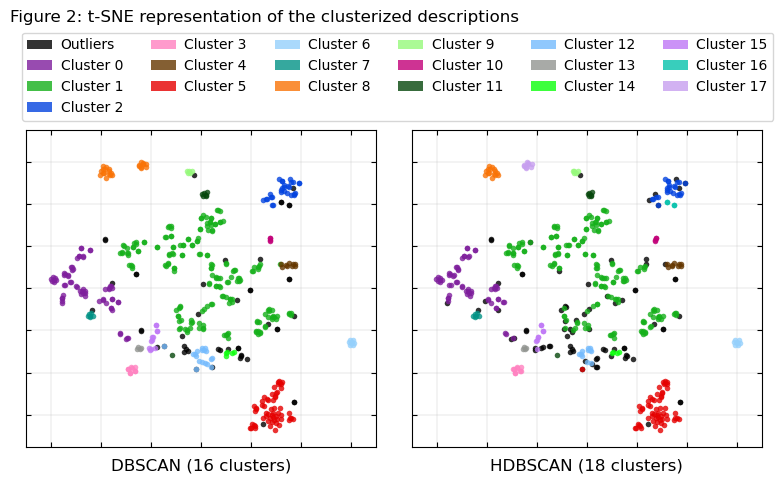

In [15]:
COLORS = [
    '#7e1e9c', '#15b01a', '#0343df', '#ff81c0', '#653700', '#e50000',
    '#95d0fc', '#029386', '#f97306', '#96f97b', '#c20078', '#06470c',
    '#75bbfd', '#929591', '#0cff0c', '#bf77f6', #'#9a0eea', '#033500',
    '#06c2ac', '#c79fef', '#00035b', '#d1b26f', '#00ffff',
    ]

##
fig2, axs2 = plt.subplots(
    nrows=1, ncols=2, sharex=True, sharey=True, figsize=(8, 4.8), dpi=100,
    gridspec_kw={'left': 0.04, 'right': 0.96, 'top': 0.73, 'bottom': 0.07, 'wspace': 0.1})
fig2.suptitle("Figure 2: t-SNE representation of the clusterized descriptions",
              x=0.02, ha='left', fontsize=12)

# legend
alpha = 0.8
handles = [Patch(facecolor='k', alpha=alpha, label='Outliers')]
handles += [Patch(facecolor=COLORS[k], alpha=alpha, label=f'Cluster {k}')
            for k in range(max(nb_dbc, nb_hdbc))]
fig2.legend(handles=handles, ncols=6, loc=(0.028, 0.75), alignment='center',
            handlelength=1.8, handletextpad=0.6)

# display outliers
idx = np.nonzero(dbc_labels == -1)[0]
line, = axs2[0].plot(embedded_tfidf[idx, 0], embedded_tfidf[idx, 1],
                     marker='.', linestyle='', color='k', alpha=alpha,
                     markersize=8, markeredgecolor='none')

# display clusters
for k in range(max(nb_dbc, nb_hdbc)):
    idx = np.nonzero(dbc_labels == k)[0]
    line, = axs2[0].plot(embedded_tfidf[idx, 0], embedded_tfidf[idx, 1],
                         marker='.', linestyle='', color=COLORS[k], alpha=alpha,
                         markersize=8, markeredgecolor='none')

axs2[0].tick_params(direction='in', labelleft=False, right=True,
                    labelbottom=False, top=True)
axs2[0].grid(visible=True, linewidth=0.2)
axs2[0].set_xlim(-70, 70)
axs2[0].set_ylim(-75, 75)
axs2[0].set_title(f'DBSCAN ({nb_dbc} clusters)', y=-0.1)


# display outliers
outlier_idx = np.nonzero(hdbc_labels == -1)[0]
axs2[1].plot(embedded_tfidf[outlier_idx, 0], embedded_tfidf[outlier_idx, 1],
             marker='.', linestyle='', color='k', alpha=alpha,
             markersize=8, markeredgecolor='none')
# display clusters
for k in range(max(nb_dbc, nb_hdbc)):
    idx = np.nonzero(new_hdbc_labels == k)[0]
    axs2[1].plot(embedded_tfidf[idx, 0], embedded_tfidf[idx, 1],
                 marker='.', linestyle='', color=COLORS[k], alpha=alpha,
                 markersize=8, markeredgecolor='none')

axs2[1].tick_params(direction='in', labelleft=False, right=True,
                    labelbottom=False, top=True)
axs2[1].grid(visible=True, linewidth=0.2)
axs2[1].set_title(f'HDBSCAN ({nb_hdbc} clusters)', y=-0.1)


plt.show()

We present a 2 dimensional t-SNE embedding of the garment descriptions in figure 2. We display the clusters obtained with both DBSCAN (left panel) and HDBSCAN (right panel) by coloring each point according to the cluster it belongs to. Re-indexing of the clusters has been done to match the labels of both clustering methods.

The data is structured as a large diffuse central cluster, with a lot of tight satellite clusters around. Both clustering methods capture well these clusters. The data at the center is the most difficult to clusterize for both DBSCAN and HDBSCAN, although the latter produce more outliers. Finally, contrary to DBSCAN, HDBSCAN is able to distinguish some satellite agreagates as distinct clusters (see data on top left).

To get insights on the actual word content of each cluster, we display the associated word clouds.

In [16]:
## Mask the bottom left to display the cluster number
mask = np.full((500, 1000), 0x0, dtype=int)
mask[420:, :110] = 0xff

## Compute word clouds for each cluster
clusters_wc = []
for k in range(-1, nb_dbc):
    text = ' '.join(corpus[np.nonzero(dbc_labels == k)])
    wc = create_wordcloud(text, min_font_size=20, mask=mask)
    clusters_wc.append(wc)
cluster_names = [f'{i}' for i in range(-1, nb_dbc)]

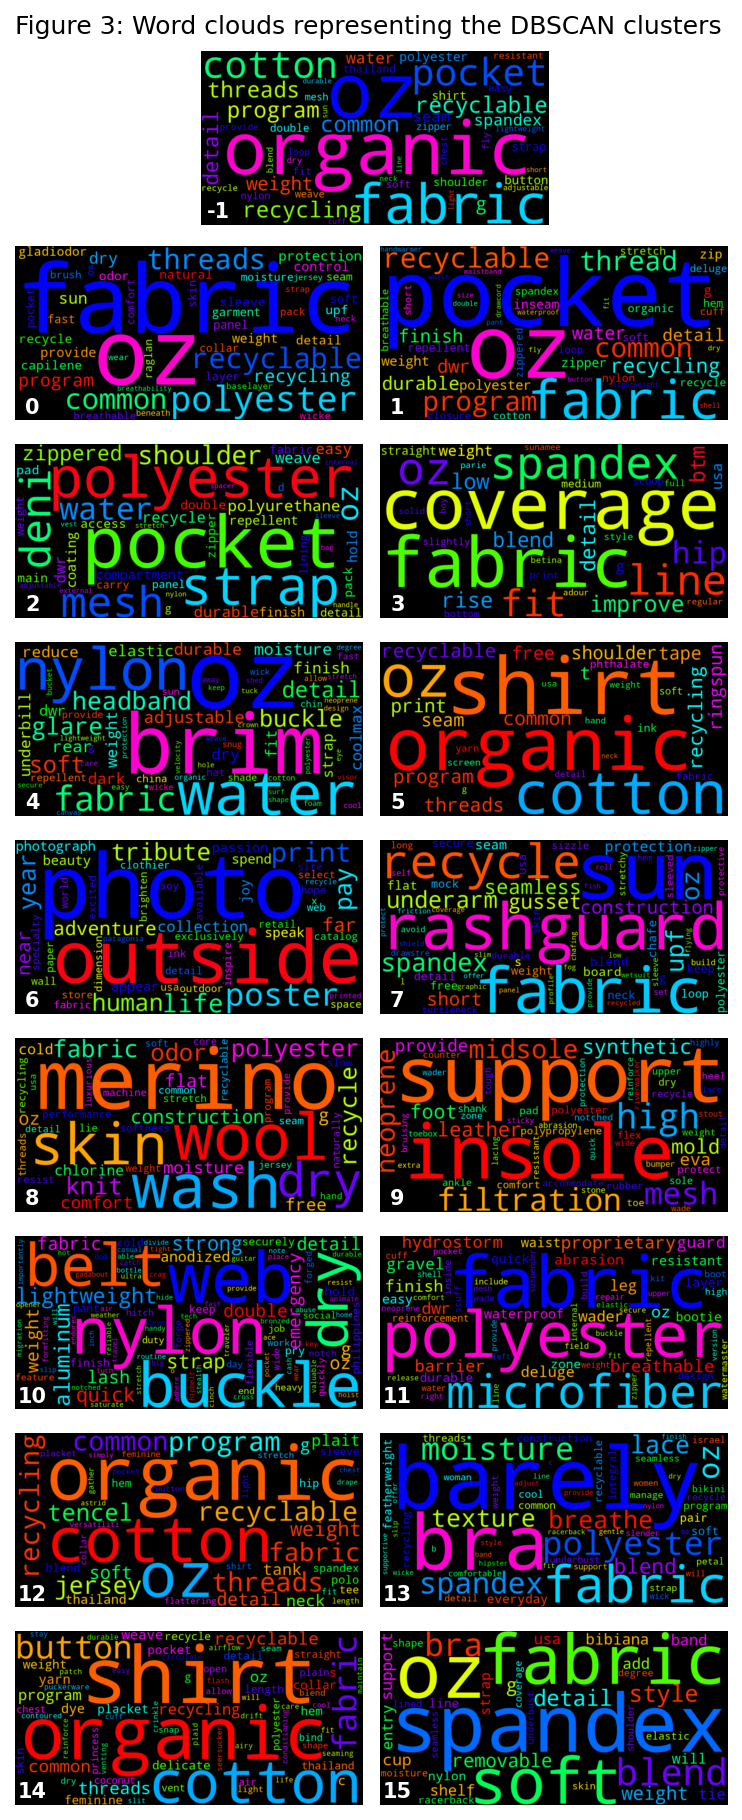

In [17]:
figsize = (5, 12.2)
fig3, axs3 = plt.subplots(
    nrows=8, ncols=2, sharey=True, figsize=figsize, dpi=150,
    gridspec_kw={'left': 0.02, 'right': 0.97, 'top': 0.865, 'bottom': 0.01,
                 'wspace': 0.05, 'hspace': 0.1})
fig3.suptitle("Figure 3: Word clouds representing the DBSCAN clusters",
              x=0.02, y=0.99, ha='left')

## clusters word clouds
for k, ax in enumerate(axs3.ravel(), start=1):
    ax.axis('off')
    ax.imshow(clusters_wc[k], interpolation='bilinear')
    ax.text(0.05, 0.04, cluster_names[k], color='w',
            fontsize=10, fontweight='bold', ha='center',
            transform=ax.transAxes)

## outlier word cloud
dx = axs3[0, 0].get_position().bounds[2]
ax3_outliers = fig3.add_axes(((1-dx)/2, 0.875, dx, dx/2*figsize[0]/figsize[1]))
ax3_outliers.axis('off')
ax3_outliers.imshow(clusters_wc[0], interpolation='bilinear')
ax3_outliers.text(0.05, 0.04, '-1', color='w',
                  fontsize=10, fontweight='bold', ha='center',
                  transform=ax3_outliers.transAxes)

plt.show()

Figure 3 presents word clouds generated from the descriptions in each cluster (inluding outliers). Although common words such as `'oz'`, `'fabric'`, `'organic', etc dominate the word clouds, we nevertheless observe interesting patterns.
- The outliers word cloud (cluster `-1`, on top) contains mostly common words, and indeed it is hard to determine which kind of items are considered outliers.
- Some cluster are clearly associated to specific items. For instance, 4: brim; 5 and 14: shirt (cluster 14 is very small); 6: photo; 7: rashguard; 9: insole/midsole; 10: belt; 13: bra.
- The other cluster are more vague, containing more generic words. This is the case for instance of cluster 1 (the largest one), which word cloud is dominated by `'pocket'`. It certainly represents garments with pockets in general.

## <a id="recommend"></a> Recommender system

As an application of the usage of TF-IDF vectors, we design a simple recommender system. The idea is very simple: for a selected item, we compute the cosine similarity between its TF-IDF vector and and those of other products and return the best matches.

We could limit our search within the cluster of the selected item for an improved computational efficiency. However, this would increase the complexity of our algorithm (need deal with the outliers), with a possible loss of performance due to the imperfect clustering. We thus favor our simple approach, implemented below.

In [18]:
descriptions_df = pd.DataFrame({'description': descriptions}, index=description_id)

def find_similar_items(item_id: int, n_items: int = 5)-> pd.DataFrame:
    
    if item_id not in descriptions_df.index:
        raise KeyError(f'no item with id={item_id}')
    
    i0 = description_id.index(item_id)
    similarities = (tfidf @ tfidf[i0].T).toarray().ravel()
    
    # indices most similar items sorted by decreasing similarity
    best_items_idx = np.argsort(similarities)[::-1]
    
    return descriptions_df.iloc[best_items_idx[1:n_items+1], 0]

In [ ]:
descriptions_df.loc[1, 'description']

Active classic boxers - There's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of 3.7-oz 100% recycled polyester with moisture-wicking performance. Inseam (size M) is 4 1/2". Recyclable through the Common Threads Recycling Program.   Details:    "Silky Capilene 1 fabric is ultralight, breathable and quick-to-dry"   "Exposed, brushed elastic waistband for comfort"   5-panel construction with traditional boxer back   "Inseam (size M) is 4 1/2"""     Fabric:  3.7-oz 100% all-recycled polyester with Gladiodor natural odor control for the garment. Recyclable through the Common Threads Recycling Program   Weight:  99 g (3.5 oz)  Made in Mexico.


In [ ]:
find_similar_items(1, n_items=5)

19     Cap 1 boxer briefs - On bivy or belay, the for...
494    Active boxer briefs - A no-fuss travel compani...
2      Active sport boxer briefs - Skinning up Glory ...
Name: description, dtype: object

We selected the first item in the list: `'Active classic boxers'`, and requested for the 5 most similar products. our recommender system returned a list of boxers and briefs, all of which belong to the same category: underwears.

## <a id="topic"></a> Topic modeling

We conclude with topic extraction from the descriptions. We do so using truncated singular value decomposition (SVD). This method allows us to recover the vectors that give the most important contribution to the whole TF-IDF matrix. These vectors actually represent the latent topics of our corpus. Truncated SVD yield them sorted by decreasing imporance in the corpus.

In [21]:
## compute only the 10 most important topics
svd = TruncatedSVD(n_components=10, random_state=1234)
svd = svd.fit(tfidf)

topics = svd.components_

In [ ]:
topic_decomp_df = pd.DataFrame(
    tfidf @ topics.T, index=description_id,
    columns=[f'topic {i}' for i in range(1, 11)])
topic_decomp_df

This dataframe represents the decomposition of items descriptions with respect to the 10 main topics. Unfortunately, this array of numbers does not permit to get an immediate intuitive idea of the topics content. We thus favor visualizing directly the topics extracted by SVD. Rather than representing the topics as abstract points on a graph, we prefer to visualize the words they refer to. Word clouds are perfectly suited for this purpose. However, contrary to TF-IDF vectors, SVD vectors have both positive and negative components. We therefore create word clouds for both positive and negative components. These are made by interpreting the absolute value of the vector coefficients as word frequencies. We could have also used the squared coefficients as word frequencies, but in practice this only suppresses words from the resulting cloud.

In [23]:
## Positive coefficients wordclouds
topics_pos = [dict(zip(vocabulary[topic > 0], topic[topic > 0]))
              for topic in topics]
topic_wordclouds_pos = [create_wordcloud(t, min_font_size=25) if t else None
                        for t in topics_pos]

## Negative coefficients wordclouds
topics_neg = [dict(zip(vocabulary[topic < 0], -topic[topic < 0]))
              for topic in topics]
topic_wordclouds_neg = [create_wordcloud(t, min_font_size=25) if t else None
                        for t in topics_neg]

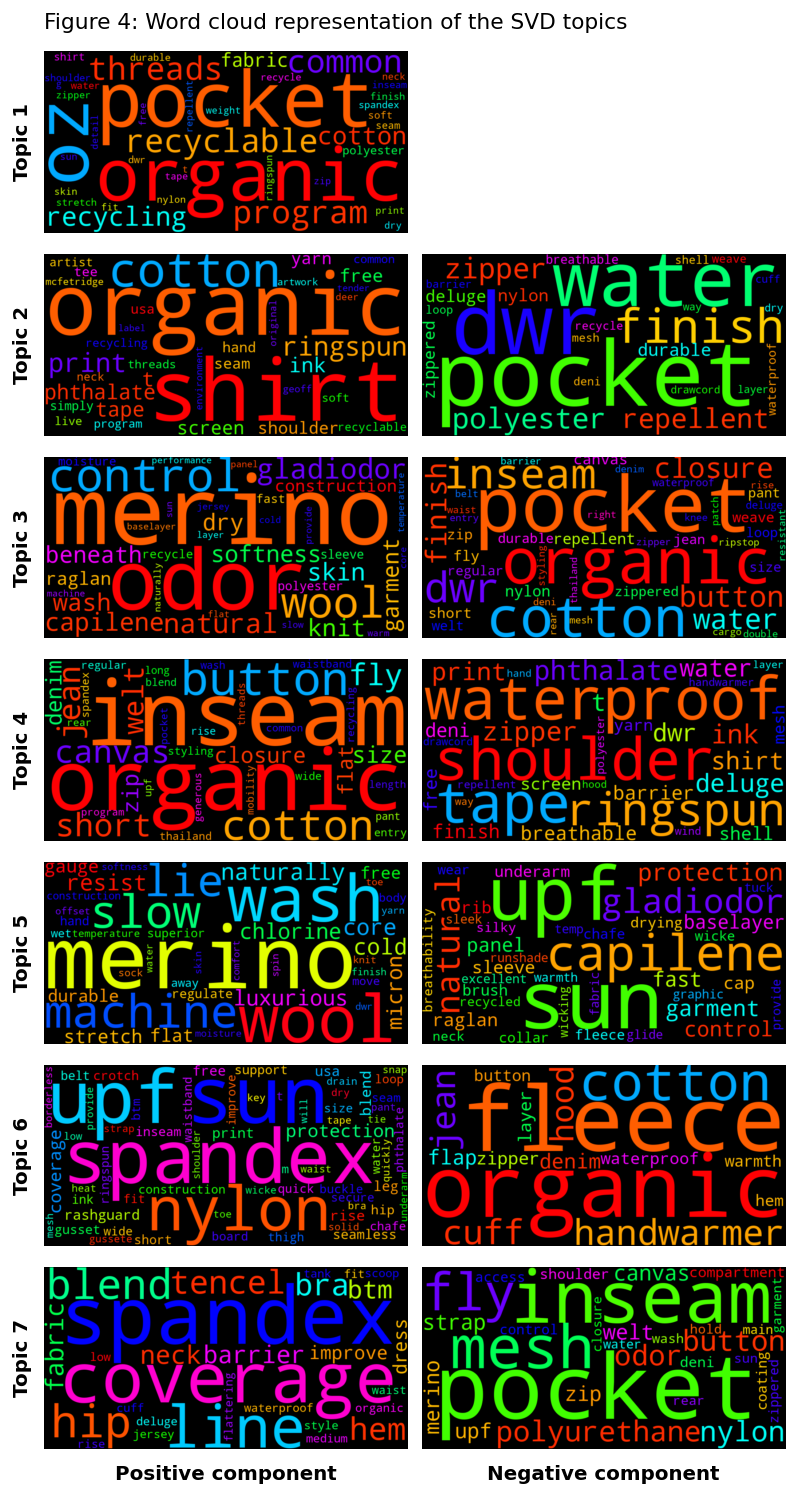

In [24]:
fig4, axs4 = plt.subplots(
    nrows=7, ncols=2, sharey=True, figsize=(6., 11.4), dpi=130,
    gridspec_kw={'left': 0.02, 'right': 0.97, 'top': 0.965, 'bottom': 0.02,
                 'wspace': 0.04, 'hspace': 0.1})
fig4.suptitle("Figure 4: Word cloud representation of the SVD topics",
              fontweight='normal', x=0.02, y=0.99, ha='left')

axs4[-1, 0].text(0.5, -0.14, 'Positive component', fontsize=11, fontweight='bold',
                transform=axs4[-1, 0].transAxes, ha='center', va='center')
axs4[-1, 1].text(0.5, -0.14, 'Negative component', fontsize=11, fontweight='bold',
                transform=axs4[-1, 1].transAxes, ha='center', va='center')

for k, axs in enumerate(axs4):
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].text(-0.06, 0.5, f'Topic {k+1}', fontsize=11, fontweight='bold',
                transform=axs[0].transAxes, ha='center', va='center', rotation=90)
    
    if topic_wordclouds_pos[k] is not None:
        axs[0].imshow(topic_wordclouds_pos[k], interpolation='bilinear')
    if topic_wordclouds_neg[k] is not None:
        axs[1].imshow(topic_wordclouds_neg[k], interpolation='bilinear')

plt.show()

Figure 4 presents word clouds representing the 7 most relevant topics calculated by trucated SVD. A topic is split into its positive (left panel) and negative (right panel) components.

The first topic has no negative component, it represents the mean of the TF-IDF vectors (which are positive). It contains words that are commong to all garment descriptions: 'oz', 'pocket', 'organic', 'thread', 'fabric'. We get interesting associations of concepts for the remaining topics. Some topics select clothing materials. For instance topic 2 selects cotton against waterproof fabric, topic 3 selects merino wool against cotton. Other topics select weather conditions. Topic 5 selects merino wool (used in cold environments) against 'UPF' (ultraviolet protection factor) and 'sun'. Topic 6 does the reverse: it selects hot weather ('sun', 'UPF') against cold weather ('fleece', 'handwarmer').

We finally note an intertwining of different semantic fields within topics. Garment elements ('pocket', 'zipper', 'button') are mixed with fabric materials ('cotton', 'merino', 'spandex') and types of garments ('shirt', 'bra', 'jean').

## <a id="conclusion"></a> Conclusion and perspectives

The intertwining of semantic fields within descriptions makes the clustering difficult. Our clustering yielded many outliers along with one large cluster containing about 40% of observations. This indicates that we were not able to properly factor out the various properties of garments.

Ideally we would like to factor a garment according to its type (shirt, bra, ...), its fabric material (cotton, polyester, ...) and some additional elements (pockets, zipper, ...). Such result could possibly be obtained with more data. Another approach would be to split the descriptions into different parts (eg the item name, its description, the fabric composition) and apply clustering to each.